In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,91.838554,10.204284,14.272448,9
Email Auth and Security,220.999920,55.249980,79.459280,4
"Jane Eyre, Bronte",384.892941,48.111618,71.268146,8
Azure VM + Developer,547.234332,16.095127,30.898854,34
TSQL,794.939803,33.122492,49.314948,24
Azure AD Authentication,867.222214,72.268518,150.167630,12
RAG Project,908.383309,100.931479,253.817150,9
Logging in Python,1031.632298,73.688021,119.107605,14
Azure Private DNS,1603.215589,84.379768,162.896006,19
C# Basics,2145.577029,69.212162,119.158108,31


# Histogram

sum of ages: ~50651.44


<Axes: >

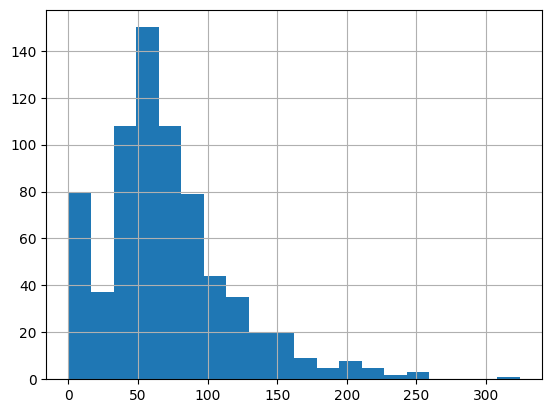

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50651.44


<Axes: >

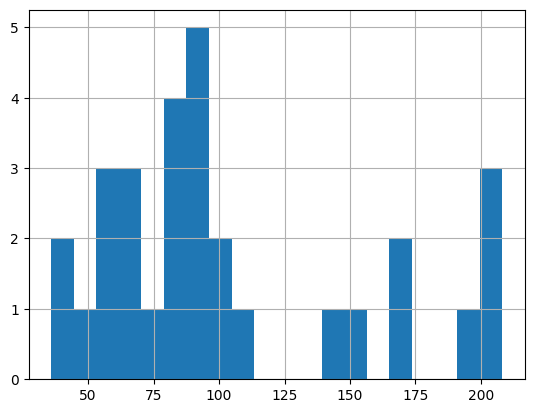

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 714
Total card age: 50651.44


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
75,Azure Developer Associate,Which role is required to generate a user dele...,4cd23bedbb8767d0fa5ef3af1af19dc8,-206.890045,60.397304,206.890045,-4046.619348,0.30792,0,0
76,Azure Developer Associate,You have 10 applications running in Azure App ...,c1271320624a1f9b6211bd726de5861d,-158.398652,60.397304,206.890045,-4046.619348,0.30792,3,0
77,Azure Developer Associate,A company plans to create an Azure Functions a...,ee25e9d85202d283c9e9b8d843c1414e,-138.077682,60.397304,206.890045,-4046.619348,0.30792,6,0
78,Azure Developer Associate,This item tests the candidate’s knowledge of u...,3fbd78188ab9535f7421be9b4746ad71,-125.960269,60.397304,206.890045,-4046.619348,0.30792,9,0
79,Azure Developer Associate,You manage an Azure event hub.\nYou need to en...,838e25a55fa8576e625cbde1871dbfd0,-121.742951,60.397304,206.890045,-4046.619348,0.30792,12,0
327,Azure Developer Associate,You have an Azure event hub. You need to add p...,e1d05b7e22576ea7494bc54377cf9d46,-111.735560,60.397304,206.890045,-4046.619348,0.30792,15,0
81,Azure Developer Associate,You can use Azure Container Registry Tasks to ...,04eb18bf91c68fbc0829733bc941c96f,-102.867980,60.397304,206.890045,-4046.619348,0.30792,18,0
329,Azure Developer Associate,You have an Azure web app that occasionally ex...,4e7adf4fdcee8e7ca9084be4ce136544,-77.514441,60.397304,206.890045,-4046.619348,0.30792,21,0
83,Azure Developer Associate,You are a developing a serverless API using Az...,e0ca187d857e4165727517c2e4b81dd6,-64.467880,60.397304,206.890045,-4046.619348,0.30792,24,0
84,Azure Developer Associate,You manage the staging and production deployme...,46318739924db6bfcf9fc3198495939c,-53.756973,60.397304,206.890045,-4046.619348,0.30792,27,0


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [16]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
169,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-324.135256,98.532074,324.135256,-2364.769782,0.342815,0,0
207,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,-253.817150,100.931479,253.817150,-908.383309,0.624173,0,0
160,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,-248.545673,100.120646,248.545673,-2603.136796,0.397773,0,0
44,Asynchronous Python,Throttling\nLimiting concurrency in Python asy...,6d8d6c93bede788bb645c334badc4faa,-244.134583,94.113201,244.134583,-3858.641235,0.634070,0,0
58,PnP PowerShell,Grant-PnPAzureADAppPermission (PnP.PowerShell)...,286cb0ddc5b9b680fc8f44ede5f20598,-237.060456,77.177338,237.060456,-3858.866905,0.063734,0,0
291,Asynchronous Python,async for (async iterator)\nUsed to iterate ov...,dbb74bcba577f12b06ddf83f9550d31b,-232.063229,94.113201,244.134583,-3858.641235,0.634070,1,1
177,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,-224.595928,102.432787,224.595928,-2151.088527,0.241839,0,0
420,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,-220.451316,102.432787,224.595928,-2151.088527,0.241839,1,1
137,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,-220.273574,94.890316,220.273574,-3036.490120,0.526279,0,0
403,Azure DevOps Pipelines,"In Azure DevOps, what command is used to run a...",5843789a2ab93c36fae15bce2e58199b,-213.097190,100.120646,248.545673,-2603.136796,0.397773,1,1


In [19]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which role is required to generate a user dele...
hash                   4cd23bedbb8767d0fa5ef3af1af19dc8c1271320624a1f...
age                                                         -1161.412434
subject_mean_age                                              603.973037
subject_highest_age                                           2068.90045
subject_age_sum                                            -40466.193476
head_random_roll                                                3.079204
count                                                                135
n_fold                                                                 0
dtype: object

In [20]:
existing_cards['age'].mean()

-70.94038693111085